In [1]:
from matplotlib import pyplot as plt
import numpy as np
from iminuit import Minuit
from scipy.stats import norm
from scipy import integrate
import random

In [2]:
class parameter_estimation:
    
    # The arguments needed to create an instance of the class are:
    # tmin : minimum decay time of the particle
    # tmax : maximum decay time of the particle
    # tau :  lifetime parameter of the prticle decay
    # V  :   Paramter which measures matter/antimattter asymmetry of the universe
    # M : the mass difference parameter
    # events : the number of events
    
    def __init__(self, tmin,tmax,tau,V, M , events ):
        self.tmin = tmin
        self.tmax = tmax
        self.tau = tau
        self.V = V
        self.M = M
        self.events = events
        self.decayTimes = []
        self.decayTimesResolution = []
        
        
        
       
        
        
    #This method generates decay times for the particle. 
    #The total number of generated decay times is the given number of numbers into the class. 
    
    def generate_decayTimes(self, f = 0):    
        self.decayTimes = []
        for i in range(self.events):
            t = self.simulatedDecayTime()
            self.decayTimes.append(t)

            
            

    #This function is the PDF of the  particle decay.
    #It evaluates the PDF using the nominal values of the parameters, ehich is passed into the class.
    
    def evaluate_PDF(self, t):
        
        return (1 + self.V*np.sin(self.M*t))* np.exp(-t/self.tau)
    
    
    # this method uses the box method to return a single decay time of the particle
    def simulatedDecayTime(self): 
        
        while True:
            
            t = np.random.uniform(self.tmin, self.tmax)
            y1 = self.evaluate_PDF(t)
            y2 = np.random.uniform(0, 1)
            
            if(y2 < y1):
                filtered_t = t
                return filtered_t
    
    
    #this method generates the decay times taking into account random errors
    
    def simulatedDecayTimeResolution(self, f):



        self.decayTimesResolution = []
        for i in range(self.events):

            while True:

                t = np.random.uniform(self.tmin, self.tmax)
                y1 = self.evaluate_PDF(t)
                y2 = np.random.uniform(0, 1)

                if(y2 < y1):

                    # the simulated decay time is from a gaussian with mean t and standard deviation of f*self.tau
                    filtered_t = random.gauss(t, f*self.tau)
                    self.decayTimesResolution.append(filtered_t)

                    break

    


        

    
    
    
    
    # This method is used to fit the decay times of the particle assuming perfect detector resolution
    def fitDecayTimes(self,T,V,delta_M ): 
        
        

            
        # getting the normalisation constant for the PDF
        PDF = lambda t, T,V,delta_M: (1 + V*np.sin(delta_M*t))* np.exp(-t/T)
        normalise = integrate.quad(PDF, self.tmin, self.tmax, args=(T , V , delta_M))

        y = np.log((1/normalise[0])* (1 + V*np.sin(delta_M*np.array(self.decayTimes)))* np.exp(-np.array(self.decayTimes)/T))
        nnl = -np.sum(y)

        self.nnl1 = nnl   #save the maximum likelihood fit
        
        return nnl
    
    

    # This method is used to fit the decay times of the particle taking into account the time resolution associated with each measurement.
    
    def fitDecayTimesResolution(self,T,V,delta_M ): 
        

        
        #getting the normalisation constant for the PDF
        PDF= lambda t, T,V,delta_M: (1 + V*np.sin(delta_M*t))* np.exp(-t/T)
        normalise = integrate.quad(PDF, self.tmin, self.tmax, args=(T , V , delta_M))
        
        y = np.log((1/normalise[0])* (1 + V*np.sin(delta_M*np.array(self.decayTimesResolution)))* np.exp(-np.array(self.decayTimesResolution)/T))
        nnl = -np.sum(y)
        self.nnl2 = nnl
        
        return nnl
    

    # This method is used to determine the systematic error.
    #The PDF is multiplied by an acceptance function
    def fitDecayTimeAcceptance(self,T,V,delta_M ): 
        
        s = random.gauss( 0 , 0.03 ) # getting s values from a Gaussian
        
        #getting the normalisation constant
        PDF = lambda t, T,V,delta_M: ((1 + V*np.sin(delta_M*t))* np.exp(-t/T))*(1 + s*t)
        normalise = integrate.quad(PDF, self.tmin, self.tmax, args=(T , V , delta_M))
        
        

        y = np.log((1/normalise[0])* ((1 + V*np.sin(delta_M*np.array(self.decayTimes)))* np.exp(-np.array(self.decayTimes)/T))*(1 + s*np.array(self.decayTimes)))

        nnl = -np.sum(y)        
        return nnl

  
    




In [3]:
#creating two class instances for 10000 events and 100000 events
decayParams1 = parameter_estimation(0 ,10 , 1.5, 0.1 , 20, 10000)
decayParams2 = parameter_estimation(0 ,10 , 1.5, 0.1 , 20, 100000)

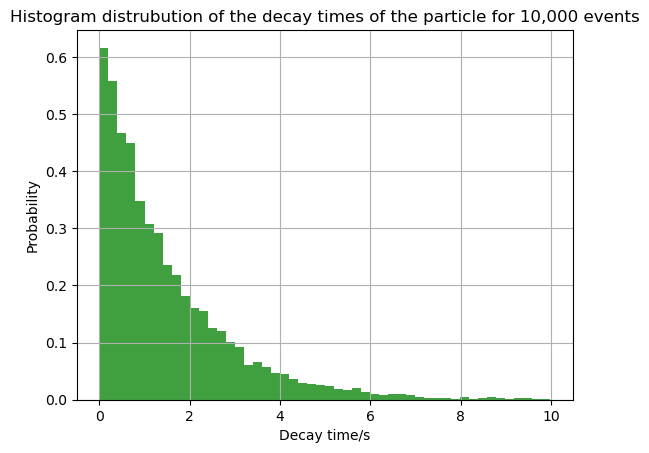

In [4]:
decayParams1.generate_decayTimes()
n, bins, patches = plt.hist(decayParams1.decayTimes, 50, density=True, facecolor='g', alpha=0.75)
plt.xlabel('Decay time/s')
plt.ylabel('Probability')
plt.title('Histogram distrubution of the decay times of the particle for 10,000 events')
plt.grid(True)
plt.show()

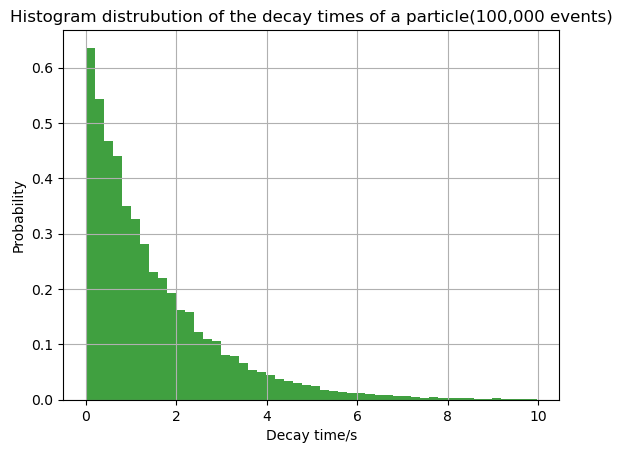

In [5]:
decayParams2.generate_decayTimes()
n, bins, patches = plt.hist(decayParams2.decayTimes, 50, density=True, facecolor='g', alpha=0.75)
plt.xlabel('Decay time/s')
plt.ylabel('Probability')
plt.title('Histogram distrubution of the decay times of a particle(100,000 events)')
plt.grid(True)
plt.show()

In order to determine the expected statistical precision with which one could measure each of the parameters, 500 different sets of decay times will be generated. For each set of decay times, Minuiut will be used to estimate the best fit for the parameters.The plot of the estimates of each paremeter will give a Gaussain distribution and, the standard deviation of the distribution will be taken as the statistical precision associsted with the parameter.   

### Part 1

In [6]:
def statistical_error(decayParams):
    #the lists below will store the estimated best parameters and their associated errors,that will be obtained for all the set of decay times. 

    T_values = []
    T_errors =[]
    V_values = []
    V_errors =[]
    M_values = []
    M_errors = []

    for i in range(500):
        

        decayParams.generate_decayTimes()   #generate a new list of decay times


        startvals ={'T' : 1.5, 'V' : 0.1 ,'delta_M' : 20.0}
        m = Minuit(decayParams.fitDecayTimes, **startvals)
        m.errordef = 0.5
        m.migrad()

        #appending the best estimates
        T_values.append(list(m.values)[0])
        V_values.append(list(m.values)[1])
        M_values.append(list(m.values)[2])

        T_errors.append(list(m.errors)[0])
        V_errors.append(list(m.errors)[1])
        M_errors.append(list(m.errors)[2])
        
        
        
    #getting the mean and standard deviation    
    lifetime_param = np.mean(np.array(T_values))
    lifetime_param_precision = np.std(np.array(T_values))

    V_param = np.mean(np.array(V_values))
    V_param_precision = np.std(np.array(V_values))


    M_param = np.mean(np.array(M_values))
    M_param_precision = np.std(np.array(M_values))

    #plotting the distribution
    plt.figure(1, figsize=(12, 3)) 

    plt.subplot(131)
    plt.xlabel('Lifetime parameter/s')
    plt.ylabel('Counts')
    plt.title("Lifetime parameter distribution")
    plt.hist(T_values, 50,density = True, facecolor='g', alpha=0.75)


    plt.subplot(132)
    plt.xlabel('V parameter')
    plt.title("V parameter distribution")
    plt.hist(V_values, 50,density = True, facecolor='g', alpha=0.75)

    plt.subplot(133)
    plt.xlabel('Mass difference parameter')
    plt.title("Mass difference parameter distribution")
    plt.hist(M_values, 50,density = True, facecolor='g', alpha=0.75)

    plt.show()
    print('Below are the means and standard deviations of the parameters of the decay from 500 experiments')
    print("Lifetime parameter: mean =  " + str(round(lifetime_param, 3)) + " ; standard deviation =  " + str(round(lifetime_param_precision, 3)))
    print("V parameter: mean =  " + str(round(V_param, 3)) + " ; standard deviation =  " + str(round(V_param_precision, 3))) 
    print("Mass difference parameter: mean =  " + str(round(M_param, 3)) + " ; standard deviation =  " + str(round(M_param_precision, 3))) 
    params = [lifetime_param, lifetime_param_precision,V_param ,V_param_precision,M_param,M_param_precision]
    return params
    

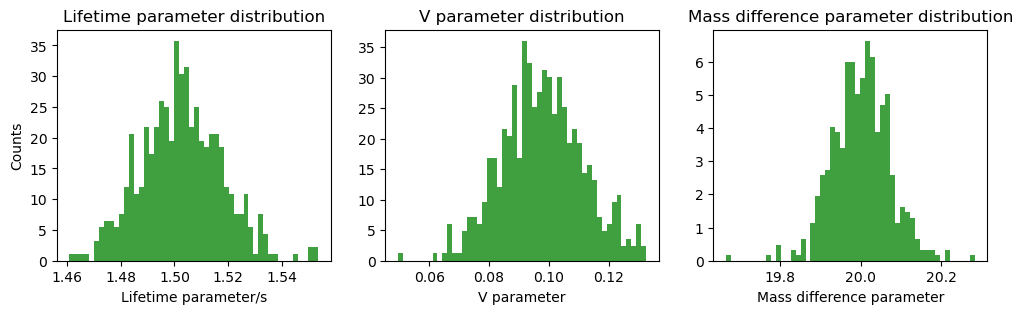

Below are the means and standard deviations of the parameters of the decay from 500 experiments
Lifetime parameter: mean =  1.503 ; standard deviation =  0.015
V parameter: mean =  0.098 ; standard deviation =  0.014
Mass difference parameter: mean =  20.001 ; standard deviation =  0.071


In [7]:
params = statistical_error(decayParams1)

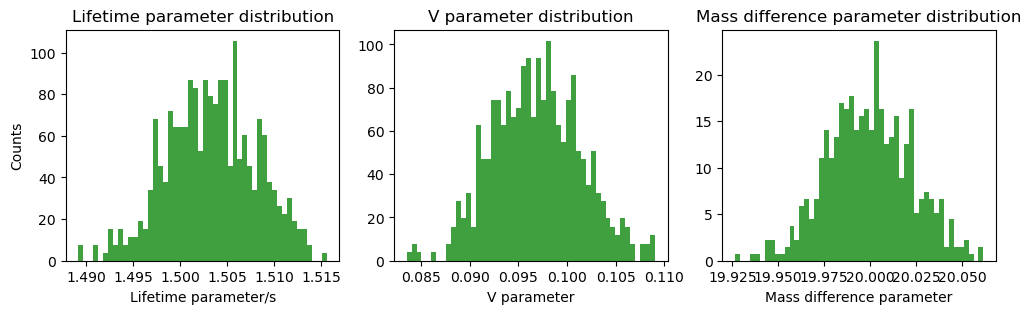

Below are the means and standard deviations of the parameters of the decay from 500 experiments
Lifetime parameter: mean =  1.503 ; standard deviation =  0.005
V parameter: mean =  0.097 ; standard deviation =  0.005
Mass difference parameter: mean =  19.999 ; standard deviation =  0.023


In [8]:
params2 = statistical_error(decayParams2)

<p> The table below gives the statistical precision with which each parameter of the decay process can be measured: </p>
<table>
    <thead>
        <td>Parameter</td>
        <td>Statistical error(10,000 events)</td>
        <td>Statistical error(100,000 events)</td>
    </thead>
    <tbody>
        <tr>
            <td>Lifetime parameter</td>
            <td> ± 0.015 </td>
            <td> ± 0.005 </td>
        </tr>
        <tr>
            <td>V Parameter</td>
            <td> ± 0.014 </td>
            <td> ± 0.005 </td>
        </tr>
        <tr>
            <td>Mass difference parameter</td>
            <td> ± 0.071 </td>
            <td> ± 0.023 </td>
        </tr>       
    </tbody> 
</table>



### Part 2

In part 2, we are interested in the bias that will be introduced to the measurement of each of the parameters, when the data is subject to the resolution effect, but this is not included into the PDF used for fitting the parameters. 
The appraoch is, the decay times will be generated for 500 experiments taking into account the resolution time. Minuit will then be used to get the best estimates of the parameters on each experiment. The plot of the best estimates of each parameter will be a Gaussian and the standard deviation will be taken as the statistical error associated with the parameter. The difference between the mean of the decay time distribution(taking into account the time resolution) and the mean of earliar distributions(perfect time resolution) in part 1 will give the bias introduced into the measurements. 

In [21]:
def random_error(f,decayParams):    
    T_values3 = []
    V_values3 =[]
    M_values3 = []





    for i in range(500):
        


        #decayParams1.simulatedDecayTimeResolution(f)  # generate a new list of decay times taking into account random errors
        decayParams.simulatedDecayTimeResolution(f) 
        startvals ={'T' : 1.5, 'V' : 0.1 ,'delta_M' : 20.0}
        m = Minuit(decayParams.fitDecayTimesResolution, **startvals)
        m.errordef = 0.5
        m.migrad()




        #appending the best estimates
        T_values3.append(list(m.values)[0])
        V_values3.append(list(m.values)[1])
        M_values3.append(list(m.values)[2])

 
        
        
        
    # getting the mean and standard deviation for the 500 experiments   
    lifetime_param3 = np.mean(np.array(T_values3))
    lifetime_param_precision3 = np.std(np.array(T_values3))

    V_param3 = np.mean(np.array(V_values3))
    V_param_precision3 = np.std(np.array(V_values3))


    M_param3 = np.mean(np.array(M_values3))
    M_param_precision3 = np.std(np.array(M_values3))




    print('The graphs below show the distribution of the parameters when random errors are accounted for in the decay times')

    #plotting the graphs
    plt.figure(1, figsize=(12, 3)) 

    plt.subplot(131)
    plt.xlabel('Lifetime parameter/s')
    plt.ylabel('Counts')
    plt.title("Lifetime parameter distribution")
    plt.hist(T_values3, 50,density = True, facecolor='g', alpha=0.75)


    plt.subplot(132)
    plt.xlabel('V parameter')
    plt.title("V parameter distribution")
    plt.hist(V_values3, 50,density = True, facecolor='g', alpha=0.75)

    plt.subplot(133)
    plt.xlabel('Mass difference parameter')
    plt.title("Mass difference parameter distribution")
    plt.hist(M_values3, 50,density = True, facecolor='g', alpha=0.75)

    plt.show()
    
    print('Below are the mean and standeard deivations of the three parameters when random errors are accounted for in the simulation of the decay times.')
    print("Lifetime parameter: mean =  " + str(round(lifetime_param3, 3)) + " ; standard deviation =  " + str(round(lifetime_param_precision3, 3)))
    print("V parameter: mean =  " + str(round(V_param3, 3)) + " ; standard deviation =  " + str(round(V_param_precision3, 3))) 
    print("Mass difference parameter: mean =  " + str(round(M_param3, 3)) + " ; standard deviation =  " + str(round(M_param_precision3, 3))) 
    print('\n')
    print('The bias introduced on the parameters by the random errors are: ')
    print("The bias on the lifetime parameter is  " + str(round(abs(lifetime_param3 - params[0]), 6)))
    print("The bias on the V parameter is  " + str(round(abs(V_param3 - params[2]), 6)))
    print("The bias on the mass difference parameter is  " + str(round(abs(M_param3 - params[4]), 6)))
        
        
        
        
        

### f = 0.01

The graphs below show the distribution of the parameters when random errors are accounted for in the decay times


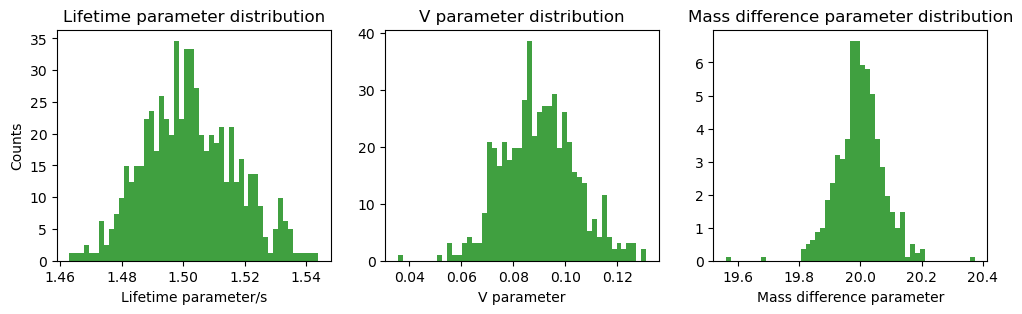

Below are the mean and standeard deivations of the three parameters when random errors are accounted for in the simulation of the decay times.
Lifetime parameter: mean =  1.502 ; standard deviation =  0.015
V parameter: mean =  0.09 ; standard deviation =  0.014
Mass difference parameter: mean =  20.0 ; standard deviation =  0.076


The bias introduced on the parameters by the random errors are: 
The bias on the lifetime parameter is  0.000366
The bias on the V parameter is  0.007887
The bias on the mass difference parameter is  0.001693


In [17]:
random_error(0.01,decayParams1)

### f = 0.03

The graphs below show the distribution of the parameters when random errors are accounted for in the decay times


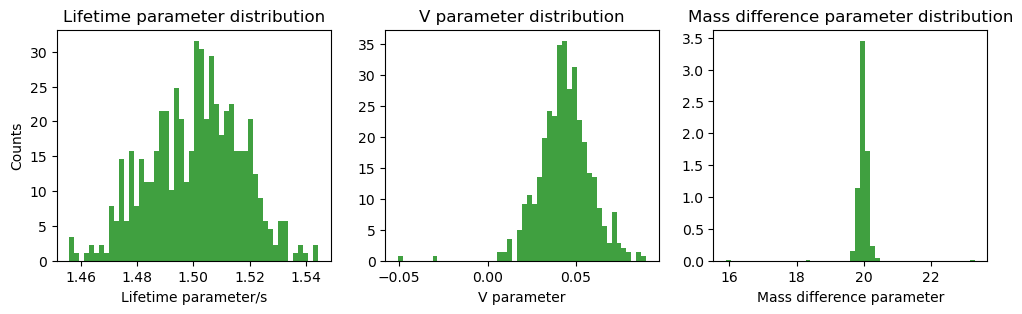

Below are the mean and standeard deivations of the three parameters when random errors are accounted for in the simulation of the decay times.
Lifetime parameter: mean =  1.501 ; standard deviation =  0.016
V parameter: mean =  0.044 ; standard deviation =  0.015
Mass difference parameter: mean =  19.98 ; standard deviation =  0.272


The bias introduced on the parameters by the random errors are: 
The bias on the lifetime parameter is  0.00168
The bias on the V parameter is  0.054104
The bias on the mass difference parameter is  0.021309


In [18]:
random_error(0.03,decayParams1)



 <p> The table below gives the bias introduced in the measurements when  random errors are accounted for </p>
<table>
    <thead>
        <td>Parameter</td>
        <td>Fraction, f = 0.01</td>
        <td>Fraction, f = 0.03</td>
    </thead>
    <tbody>
        <tr>
            <td>Lifetime parameter</td>
            <td>  0.00037 </td>
            <td>  0.0017</td>
        </tr>
        <tr>
            <td>V Parameter</td>
            <td> ± 0.0079 </td>
            <td> ± 0.054</td>
        </tr>
        <tr>
            <td>Mass difference parameter</td>
            <td> ± 0.0017 </td>
            <td> ± 0.021 </td>
        </tr>       
    </tbody> 
</table>
<p> As seen from the table above, accounting for the random error in each measurement introduces very little bias to the measurement. Also, the lower the fraction used to get the random errors, the lower the bias</p>


### Part 3

In part 3, we are interested in determing the systematic error to assign to each of the parameters due to our limited knowledge of the decay-time acceptance,a(t). <br>
a(t) = (1 + st)<br>
s is only known with a precision of s = 0 ± 0.03.
                                                                     
In determing the systematic error, the PDF of the decay process was multiplied by the decay-time acceptance function and normalised. Minuit was then used to fit the corresponding PDF to get the best estimates of the parameters. For each fit, random values of s from a Gaussian distribution centred on 0 with width of 0.03 was used. Using the same set of decay times, the fit was re-run with s = 0 . The change in the parameters was recorded and stored in a list. The process was repeated for 500 experiments. The plot of the shifts for each parameter should give a Gaussian and, the standard deviation is taken as the systematic error.


In [19]:
def systematic_error(decayParams):
    lifetime_shift = []
    V_shift = []
    M_shift = []


    #must fit twice to same dataset
    for i in range(500):
        
        decayParams.generate_decayTimes()
        startvals ={'T' : 1.5, 'V' : 0.1 ,'delta_M' : 20.0}
        m = Minuit(decayParams.fitDecayTimeAcceptance, **startvals)
        m.errordef = 0.5
        m.migrad()

        m1 = Minuit(decayParams.fitDecayTimes, **startvals)
        m1.errordef = 0.5
        m1.migrad()


        #this if-else statement prevent taking into account values computed with integration warning.
        if abs((list(m.values)[0] - list(m1.values)[0])) > 5 or abs((list(m.values)[1] - list(m1.values)[1])) > 5 or abs((list(m.values)[2] - list(m1.values)[2])) > 5:
            pass

        else:
            lifetime_shift.append((list(m.values)[0] - list(m1.values)[0]))
            V_shift.append((list(m.values)[1] - list(m1.values)[1] ))
            M_shift.append((list(m.values)[2] - list(m1.values)[2]))
            
    #getting the mean and standard deviation
    lifetime_shift_mean = np.mean(np.array(lifetime_shift))
    lifetime_shift_precision = np.std(np.array(lifetime_shift))

    V_shift_mean = np.mean(np.array(V_shift))
    V_shift_precision = np.std(np.array(V_shift))


    M_shift_mean = np.mean(np.array(M_shift))
    M_shift_precision = np.std(np.array(M_shift))

    
    # plotting the shift distributions
    plt.figure(1, figsize=(15, 3)) 

    plt.subplot(131)
    plt.xlabel('Shift in lifetime parameter/s')
    plt.ylabel('Counts')
    plt.title("Shift in lifetime parameter distribution")
    plt.hist(lifetime_shift, 50,density = True, facecolor='g', alpha=0.75)


    plt.subplot(132)
    
    
    
    plt.xlabel('Shift in V parameter')
    plt.title("Shift in V parameter distribution")
    plt.hist(V_shift, 50,density = True, facecolor='g', alpha=0.75)

    plt.subplot(133)
    plt.xlabel('Shift in mass difference parameter')
    plt.title("Shift in mass difference parameter distribution")
    plt.hist(M_shift, 50,density = True, facecolor='g', alpha=0.75)

    plt.show()
    
    
    print("Shift in lifetime parameter: mean =  " + str(round(lifetime_shift_mean, 3)) + " ; standard deviation =  " + str(round(lifetime_shift_precision, 3)))
    print("Shift in V parameter: mean =  " + str(round(V_shift_mean, 3)) + " ; standard deviation =  " + str(round(V_shift_precision, 3))) 
    print("Shift in mass difference parameter: mean =  " + str(round(M_shift_mean, 3)) + " ; standard deviation =  " + str(round(M_shift_precision, 3))) 




/var/folders/sl/3pszjjd95ks506qykf9w8w7r0000gn/T/ipykernel_1019/1014048206.py:140: RuntimeWarning: invalid value encountered in log
  y = np.log((1/normalise[0])* ((1 + V*np.sin(delta_M*np.array(self.decayTimes)))* np.exp(-np.array(self.decayTimes)/T))*(1 + s*np.array(self.decayTimes)))
/var/folders/sl/3pszjjd95ks506qykf9w8w7r0000gn/T/ipykernel_1019/1014048206.py:136: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  normalise = integrate.quad(PDF, self.tmin, self.tmax, args=(T , V , delta_M))
/var/folders/sl/3pszjjd95ks506qykf9w8w7r0000gn/T/ipykernel_1019/1014048206.py:136: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) on

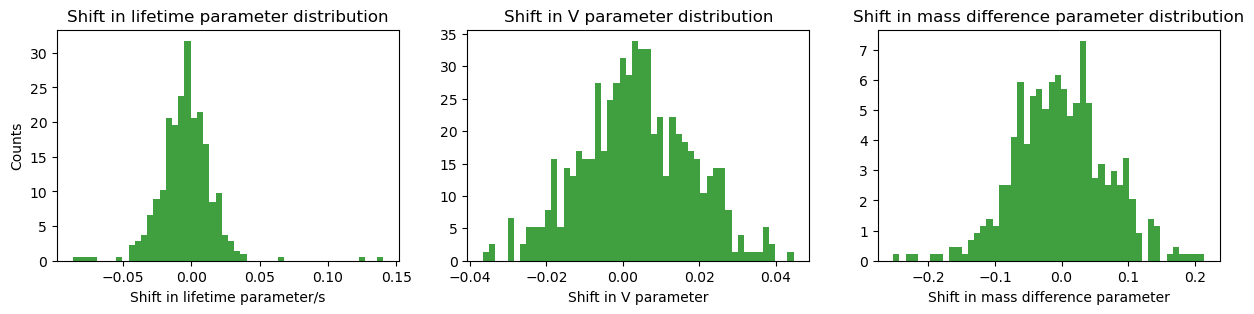

Shift in lifetime parameter: mean =  -0.004 ; standard deviation =  0.019
Shift in V parameter: mean =  0.003 ; standard deviation =  0.014
Shift in mass difference parameter: mean =  -0.001 ; standard deviation =  0.069


In [20]:
systematic_error(decayParams1)



 <p> The table below gives the systematic error on each parameter, using the given knowlegde of the acceptance function. This is done for 10000 events.</p>
<table>
    <thead>
        <td>Parameter</td>
        <td>Systematic error</td>   
        <td> statistical error </td>
    </thead>
    <tbody>
        <tr>
            <td>Lifetime parameter</td>
            <td> ± 0.019 </td>     
            <td> ± 0.015 </td>
        </tr>
        <tr>
            <td>V Parameter</td>
            <td> ± 0.014 </td>   
            <td> ± 0.014 </td>
        </tr>
        <tr>
            <td>Mass difference parameter</td>
            <td> ± 0.069 </td>   
            <td>0.071 </td>
        </tr>       
    </tbody> 
</table>



As seen from the table above, the systematuc error is significantly lower than the statistical error and, in the case of the lifetime parameter, the systematic error is even greater than the statistical error. This reduces the confidence in the measured decay times and, the knowledge of the acceptance function of the detector needs to be improved. 